# Setup and data import

In [1]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt

In [2]:
staticfile = "/home/glemieux/Data/luh2/staticData_quarterdeg.nc"
targetfile = '/home/glemieux/Data/surfdat/surfdata_4x5_16pfts_Irrig_CMIP6_simyr2000_c170824.nc'
clmsurffile = '/home/glemieux/Data/luh2/lu-pft/CLM5_current_surf_deg025.nc'
forestfile = '/home/glemieux/Data/luh2/lu-pft/CLM5_current_luhforest_deg025.nc'
otherfile = '/home/glemieux/Data/luh2/lu-pft/CLM5_current_luhother_deg025.nc'
pasturefile = '/home/glemieux/Data/luh2/lu-pft/CLM5_current_luhpasture_deg025.nc'

In [3]:
ds_static = xr.open_dataset(staticfile)
ds_target = xr.open_dataset(targetfile)
ds_clmsurf = xr.open_dataset(clmsurffile)
ds_forest = xr.open_dataset(forestfile)
ds_other = xr.open_dataset(otherfile)
ds_pasture = xr.open_dataset(pasturefile)
ds_clmlist = [ds_clmsurf,ds_forest,ds_pasture,ds_other]

## Prepare landuse data

Note that the lat/lon dimensions/coordinates for the target are named `lsmlat/lsmlon` and need conversion before comparison or regridding

In [4]:
ds_target = ds_target.rename_dims(dims_dict={'lsmlat':'latitude','lsmlon':'longitude'})
ds_target['longitude'] = ds_target.LONGXY.isel(latitude=0)
ds_target['latitude'] = ds_target.LATIXY.isel(longitude=0)

Convert the clm5 data to lat/lon degrees and create percentage and bareground data

In [5]:
percent = []
bareground = []
for i,ds in enumerate(ds_clmlist):
    # First convert to lat/lon
    ds['lat'] = ds.LAT
    ds['lon'] = ds.LON
    temppercent = ds.PCT_NAT_PFT.isel(natpft=slice(1,None))
    temppercent = temppercent / temppercent.sum(dim='natpft')
    percent.append(temppercent)
    bareground.append(ds.PCT_NAT_PFT.isel(natpft=0))

# TODO: compute prim + secnd percent

In [87]:
primary_secondary_percent = ds_static.fstnf * percent[1] + (1.- ds_static.fstnf) * percent[2]

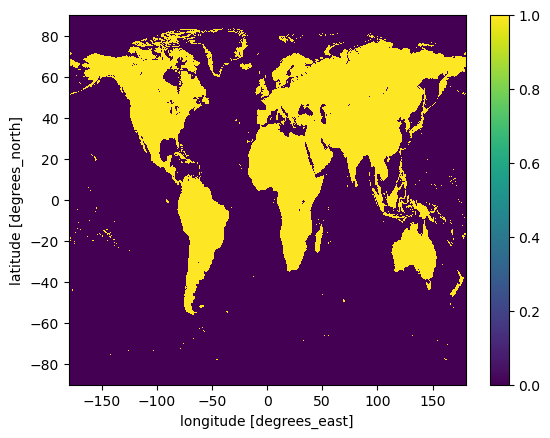

In [92]:
primary_secondary_percent.sum(dim='natpft').plot()

# Universal masks

## Regrid target mask

This is the mask that should be applied to the target dataset

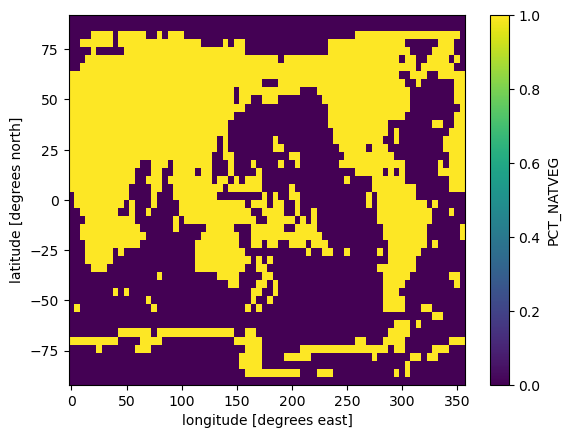

In [6]:
mask_target = xr.where(ds_target.PCT_NATVEG > 0,1,0)
mask_target.plot()

# Ice water mask from LUH2 static data

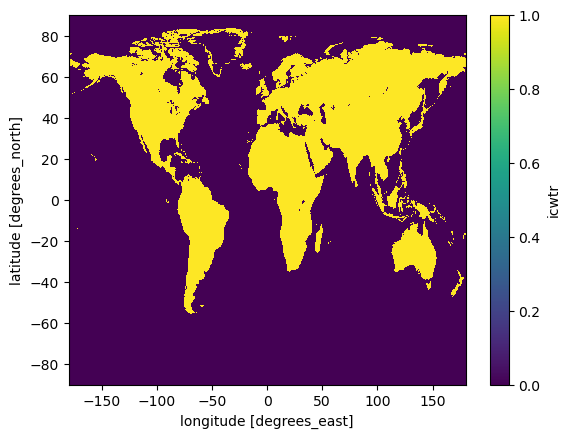

In [66]:
icwtr = ds_static.icwtr.astype('float64')
mask_icwtr = xr.where(icwtr != 1,1,0)
mask_icwtr.plot()

# Masks by landuse type

## Compute and plot where bareground is 100% for each type

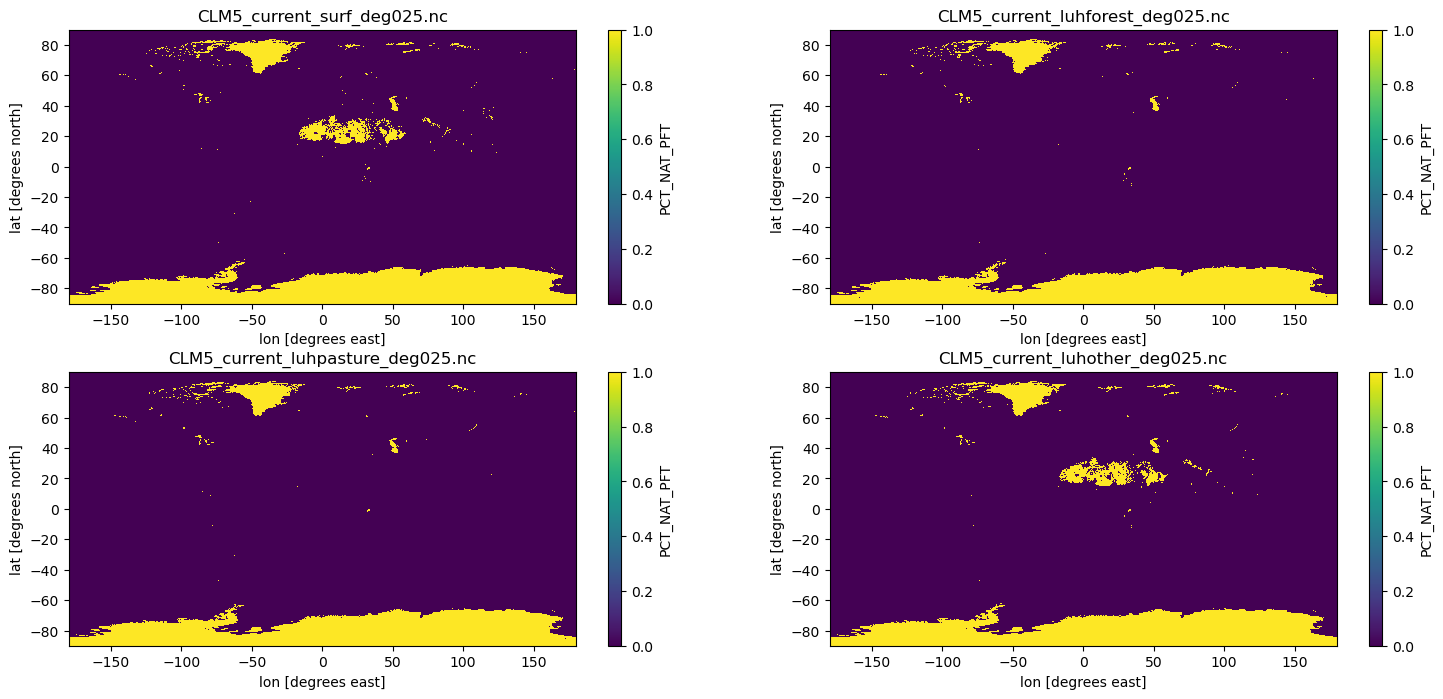

In [68]:
mask_allbareground = []
f, ax = plt.subplots(2, 2, figsize=(18, 8))
plt.subplots_adjust(hspace=0.25)
for i,ai in enumerate(ax.flat):
    mask_allbareground.append(xr.where(bareground[i] == 100.,1,0))
    mask_allbareground[i].plot(ax=ai)
    ai.set_title(ds_clmlist[i].title)

### How do these 100% compare to each other?

CLM5_current_surf_deg025.nc
CLM5_current_luhforest_deg025.nc
CLM5_current_luhpasture_deg025.nc
CLM5_current_luhother_deg025.nc


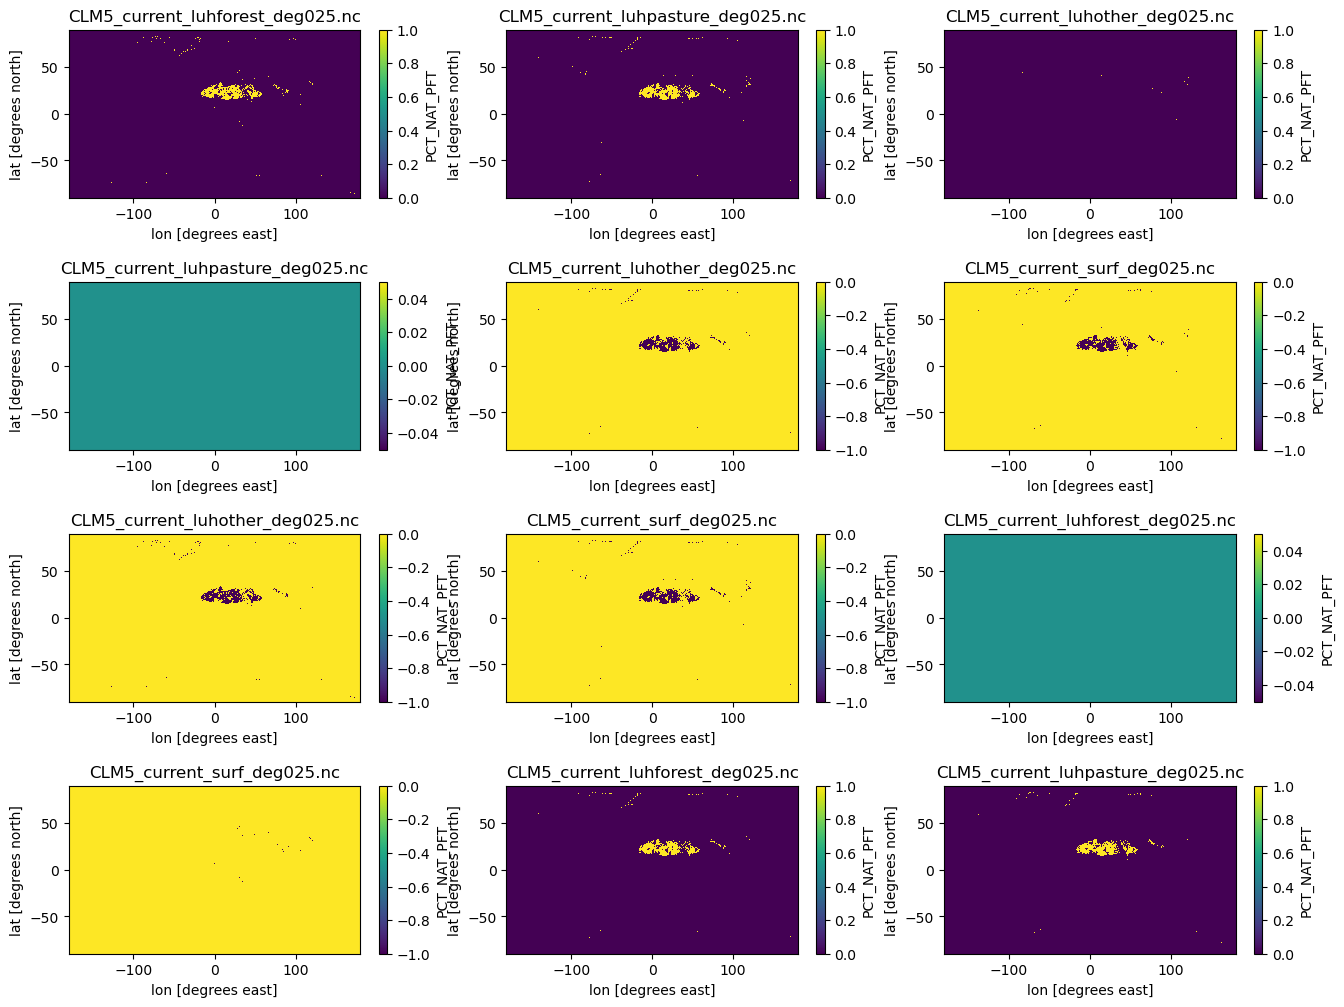

In [53]:
rows = 4
cols = 3
f, ax = plt.subplots(rows, cols, figsize=(16, 12))
plt.subplots_adjust(hspace=0.5)
idx = np.array([1,2,3,0])
for i,ai in enumerate(ax.flat):
    imod = np.mod(i,cols)
    if imod == 0:
        # Plot the index of the current row being compared against
        print(ds_clmlist[idx[-1]].title)
    (mask_allbareground[idx[-1]]-mask_allbareground[idx[imod]]).plot(ax=ai)
    ai.set_title(ds_clmlist[idx[imod]].title)
    if imod == 2:
        # Shift the idx array to the left when we get to the end
        idx = np.roll(idx,-1)

**Forest and Pasture 100% bareground are the same**.  Surface has a few additional data points than Other.

## Compute and plot where bareground is NaN for each type

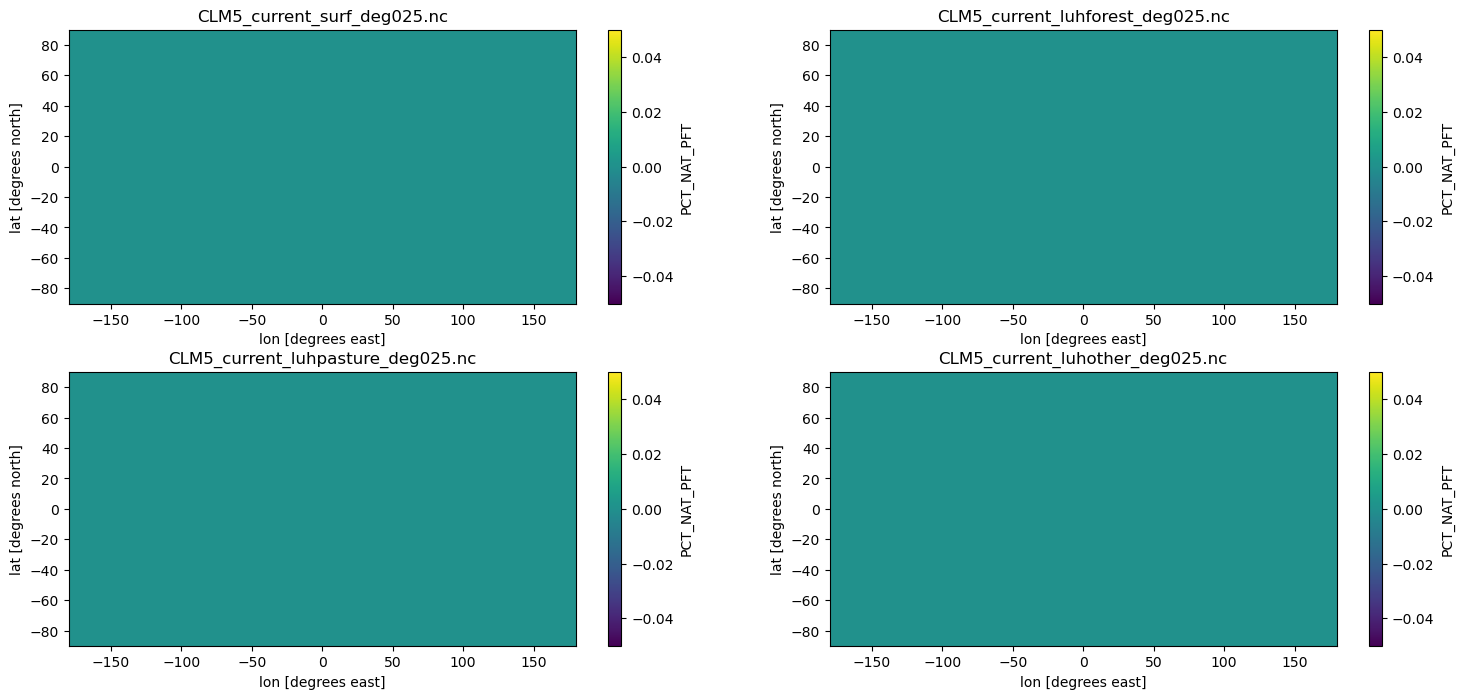

In [98]:
mask_nanbareground = []
f, ax = plt.subplots(2, 2, figsize=(18, 8))
plt.subplots_adjust(hspace=0.25)
for i,ai in enumerate(ax.flat):
    mask_nanbareground.append(xr.where(np.isnan(bareground[i]),1,0))
    mask_nanbareground[i].plot(ax=ai)
    ai.set_title(ds_clmlist[i].title)

Conclusion: **There appears to be no `NaN` data for the bareground prior to any sort of manipulation.**

## Compute where sum of landuse percent is zero

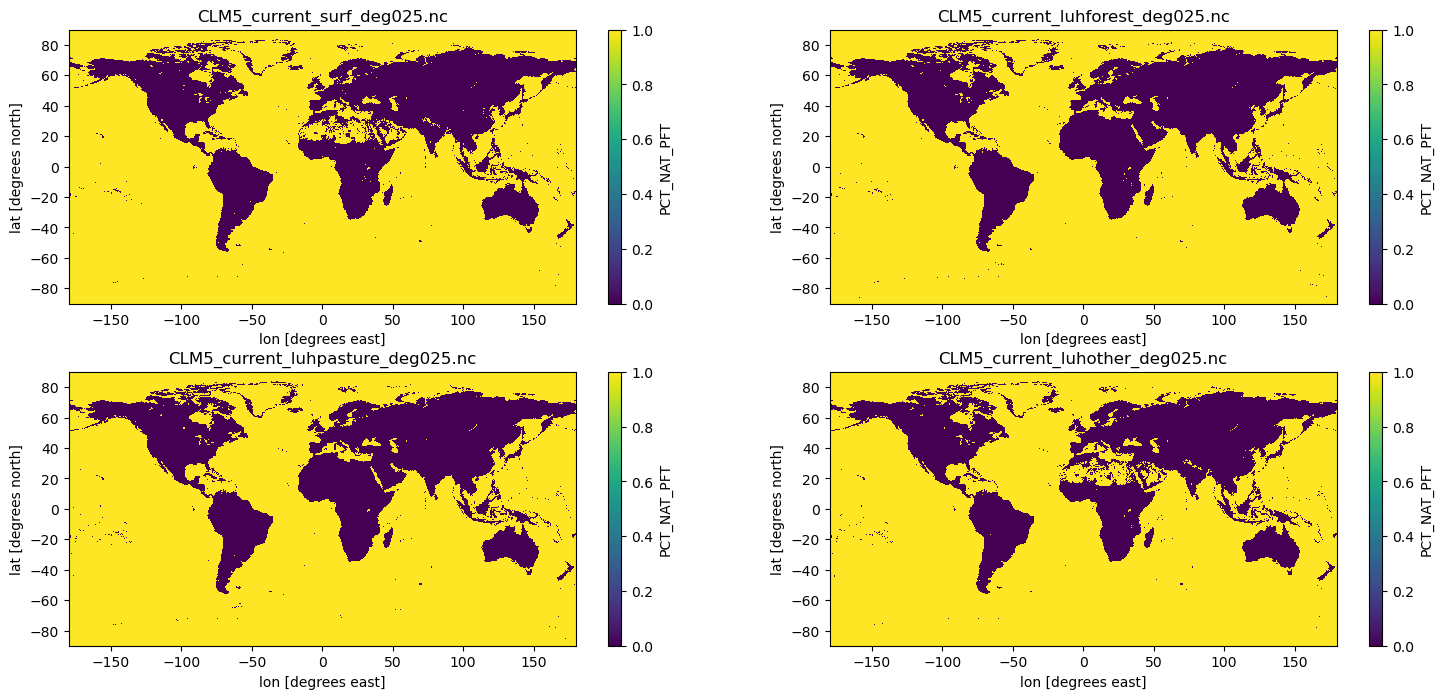

In [102]:
mask_zeropercent = []
f, ax = plt.subplots(2, 2, figsize=(18, 8))
plt.subplots_adjust(hspace=0.25)
for i,ai in enumerate(ax.flat):
    mask_zeropercent.append(xr.where(percent[i].sum(dim='natpft') == 0.,1,0))
    mask_zeropercent[i].plot(ax=ai)
    ai.set_title(ds_clmlist[i].title)

### How do these 0% landuse compare to each other?

CLM5_current_surf_deg025.nc
CLM5_current_luhforest_deg025.nc
CLM5_current_luhpasture_deg025.nc
CLM5_current_luhother_deg025.nc


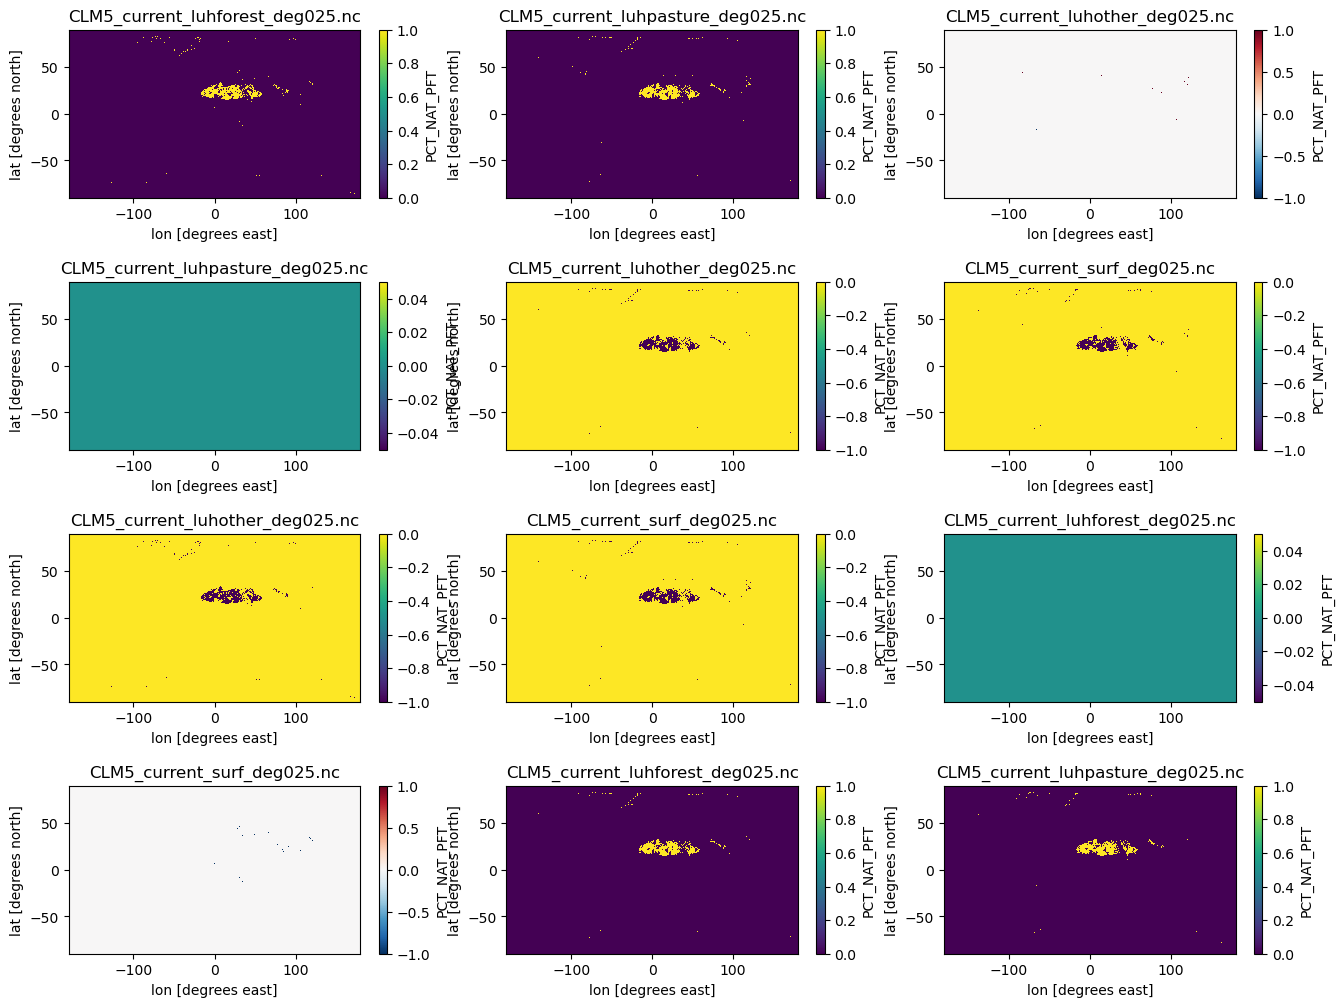

In [103]:
rows = 4
cols = 3
f, ax = plt.subplots(rows, cols, figsize=(16, 12))
plt.subplots_adjust(hspace=0.5)
idx = np.array([1,2,3,0])
for i,ai in enumerate(ax.flat):
    imod = np.mod(i,cols)
    if imod == 0:
        print(ds_clmlist[idx[-1]].title)
    (mask_zeropercent[idx[-1]]-mask_zeropercent[idx[imod]]).plot(ax=ai)
    ai.set_title(ds_clmlist[idx[imod]].title)
    if imod == 2:
        idx = np.roll(idx,-1)

**Again, pasture and forest landuse are the same**.  Surface and Other has some data missing from each, however, which is different from last time.

## How do the 100% bareground and 0% landuse compare?

Look at where they are the same and diff where they are different

In [104]:
for idx in range(4):
    print(ds_clmlist[idx].title)
    # print("Is the muliplication of the 100% and 0% the same as 0%: ", (mask_zeropercent[idx] == (mask_zeropercent[idx] * mask_allbareground[idx])).all().values)
    print("Is the muliplication of the 100% and 0% zero: ", ((1-mask_zeropercent[idx]) * mask_allbareground[idx] == 0.).all().values)
    print()

CLM5_current_surf_deg025.nc
Is the muliplication of the 100% and 0% zero:  True

CLM5_current_luhforest_deg025.nc
Is the muliplication of the 100% and 0% zero:  True

CLM5_current_luhpasture_deg025.nc
Is the muliplication of the 100% and 0% zero:  True

CLM5_current_luhother_deg025.nc
Is the muliplication of the 100% and 0% zero:  True



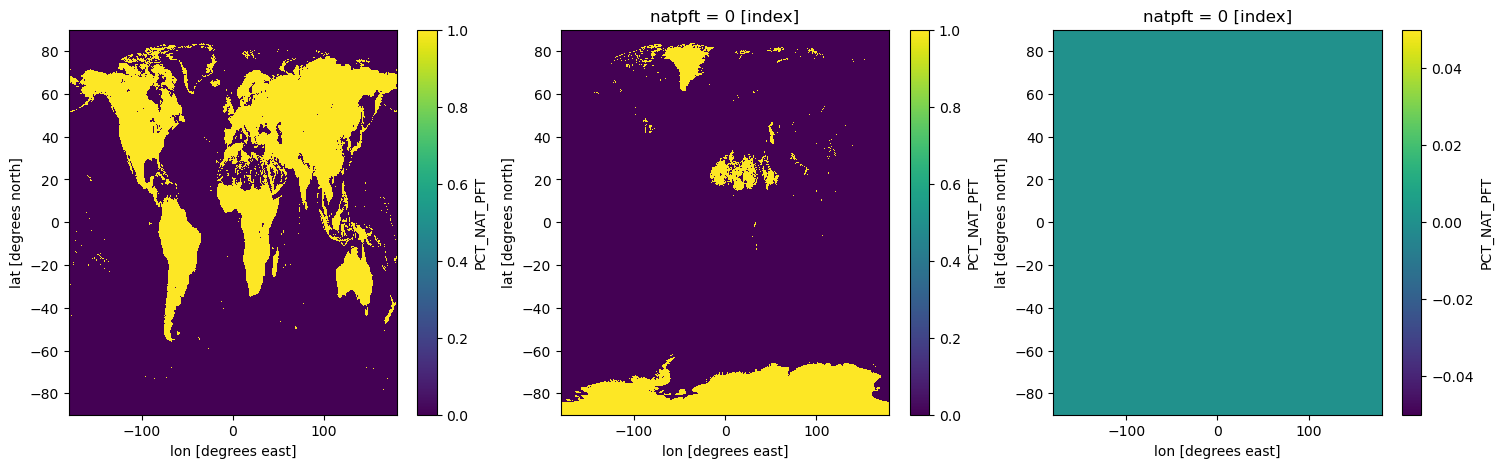

In [105]:
# Multiply to see where they are the same
idx = 0
f, ax = plt.subplots(1, 3, figsize=(18, 5))
(1-mask_zeropercent[idx]).plot(ax=ax[0])
mask_allbareground[idx].plot(ax=ax[1])
((1-mask_zeropercent[idx]) * mask_allbareground[idx]).plot(ax=ax[2])

**Since the multiplication of the inverse of zero percent and allbareground within each landuse type is the same as zero, they have are perfect inverses of each other for each lutype**.

For "pure" lupft type data, this seems to suggest that we really only need to consider using one or the other.

## Compare icewater and bareground

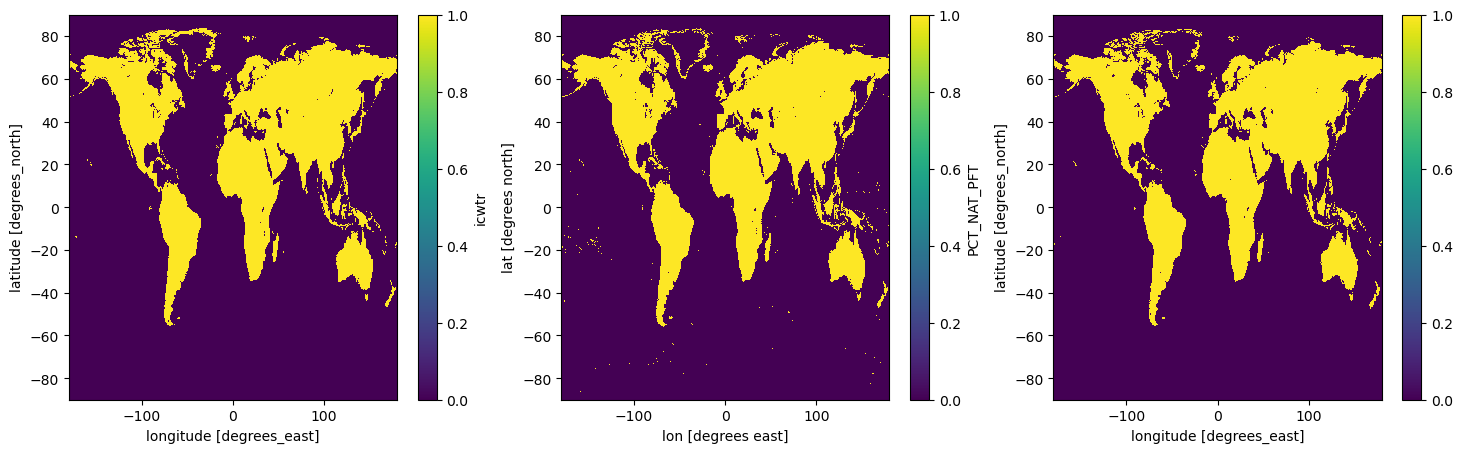

In [117]:
idx = 2
f, ax = plt.subplots(1, 3, figsize=(18, 5))
mask_icwtr.plot(ax=ax[0])
(1-mask_zeropercent[idx]).plot(ax=ax[1])
(mask_icwtr * (1-mask_zeropercent[idx])).plot(ax=ax[2])

**Conclusion: neither lupft or luh2 icwtr contain each other**

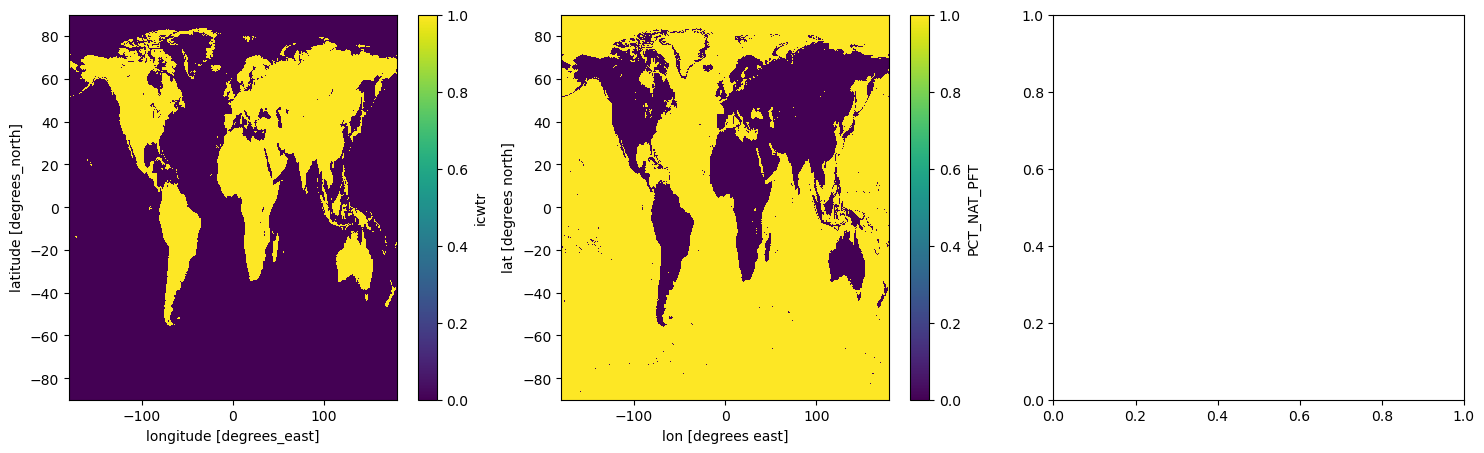

In [107]:
idx = 2
f, ax = plt.subplots(1, 3, figsize=(18, 5))
mask_icwtr.plot(ax=ax[0])
mask_zeropercent[idx].plot(ax=ax[1])

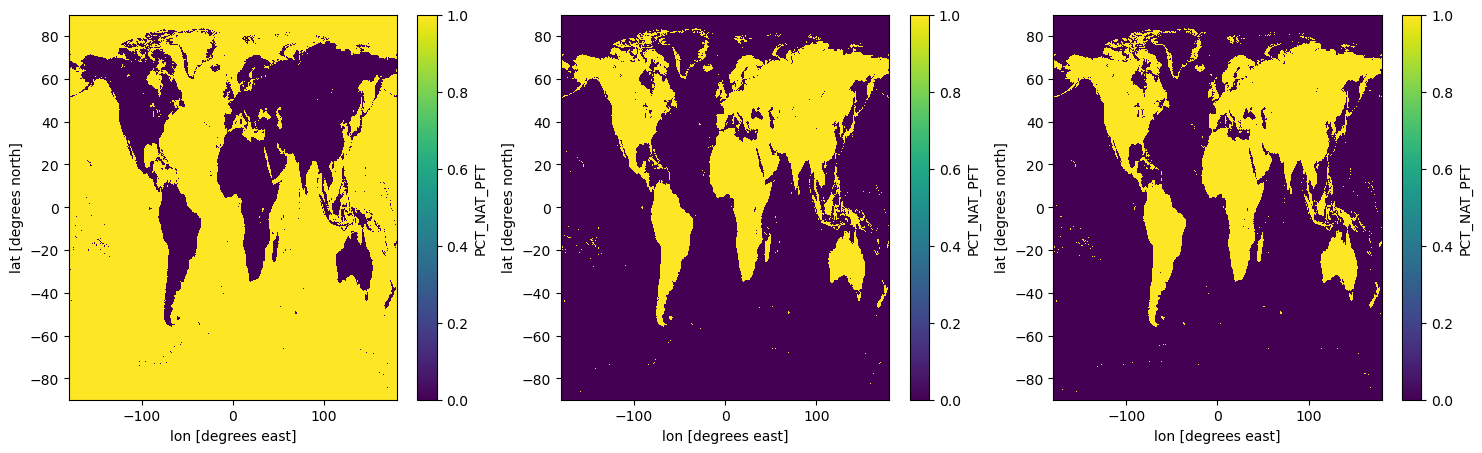

In [111]:
idx = 2
f, ax = plt.subplots(1, 3, figsize=(18, 5))
(xr.where(percent[2].sum(dim='natpft') == 0.,1,0)).plot(ax=ax[0])
(xr.where(percent[2].sum(dim='natpft') == 0.,0,1)).plot(ax=ax[1])
(1-(xr.where(percent[2].sum(dim='natpft') == 0.,1,0))).plot(ax=ax[2])

In [116]:
((xr.where(percent[2].sum(dim='natpft') == 0.,0,1)) == (1-(xr.where(percent[2].sum(dim='natpft') == 0.,1,0)))).all().values

array(True)